# Prispevek Luke Koper k prometnim zastojem
# Port of Koper Contribution to Traffic Congestion

**Hipoteza H3**: Tovorni promet Luke Koper ne povzroča kritičnih zastojev izven špic

**Cilj**: Kvantificirati vpliv pristaniškega tovornega prometa na zastoje s pomočjo Bayesove vzročne analize

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Nastavitve za slovenščino in vizualizacije
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
az.style.use('arviz-darkgrid')

print("Knjižnice naložene uspešno")

Knjižnice naložene uspešno


## 1. Nalaganje in priprava podatkov

In [15]:
# Nalaganje podatkov o prometu in hitrosti
print("Nalaganje podatkov...")

# Podatki o štetju vozil
df_count = pd.read_csv('../data/production_merged_vehicle_count.csv', 
                       parse_dates=['datetime'],
                       low_memory=False)

# Podatki o hitrosti vozil
df_speed = pd.read_csv('../data/production_merged_vehicle_speed.csv',
                       parse_dates=['datetime'],
                       low_memory=False)

# Združi podatke
df = pd.merge(df_count, df_speed[['datetime', 'road_code', 'Avg_Speed']], 
              on=['datetime', 'road_code'], how='left')

# Filter za Koprsko območje
koper_segments = ['0161', '0011', '0111', '0211']
koper_roads = ['Koper', 'Bertoki', 'Srmin', 'Škofije']

df_koper = df[
    (df['road_code'].isin(koper_segments)) |
    (df['road_name'].str.contains('|'.join(koper_roads), case=False, na=False))
].copy()

print(f"Združenih {len(df_koper):,} zapisov")
print(f"Obdobje: {df_koper['datetime'].min()} do {df_koper['datetime'].max()}")

Nalaganje podatkov...
Združenih 525,888 zapisov
Obdobje: 2020-08-30 00:00:00 do 2025-08-29 23:00:00


In [16]:
# Izračun metrik zastojev
# Predpostavka: Normalna hitrost na avtocesti je 100-130 km/h
NORMAL_SPEED_MIN = 80  # km/h
CONGESTED_SPEED = 60   # km/h - prag za zastoje
SEVERE_CONGESTION = 40 # km/h - prag za hude zastoje

# Dodaj časovne značilke
df_koper['hour'] = df_koper['datetime'].dt.hour
df_koper['dayofweek'] = df_koper['datetime'].dt.dayofweek
df_koper['is_weekend'] = df_koper['dayofweek'].isin([5, 6])
df_koper['month'] = df_koper['datetime'].dt.month

# Izračun metrik
df_koper['is_congested'] = df_koper['Avg_Speed'] < CONGESTED_SPEED
df_koper['is_severe_congestion'] = df_koper['Avg_Speed'] < SEVERE_CONGESTION
df_koper['speed_reduction'] = np.maximum(0, NORMAL_SPEED_MIN - df_koper['Avg_Speed'])
df_koper['occupancy'] = df_koper['Total_All_Lanes'] / 2000  # Normalizirana zasedenost (max 2000 vozil/uro/pas)
df_koper['truck_ratio'] = df_koper['Trucks_7.5t'] / df_koper['Total_All_Lanes']

# Kategorizacija prometnih razmer
def categorize_traffic(speed):
    if pd.isna(speed):
        return 'Neznano'
    elif speed >= NORMAL_SPEED_MIN:
        return 'Prosto'
    elif speed >= CONGESTED_SPEED:
        return 'Gost promet'
    elif speed >= SEVERE_CONGESTION:
        return 'Zastoj'
    else:
        return 'Hud zastoj'

df_koper['traffic_state'] = df_koper['Avg_Speed'].apply(categorize_traffic)

print("\n=== PORAZDELITEV PROMETNIH STANJ ===")
print(df_koper['traffic_state'].value_counts(normalize=True).round(3) * 100)


=== PORAZDELITEV PROMETNIH STANJ ===
traffic_state
Prosto         88.5
Gost promet    11.4
Zastoj          0.1
Name: proportion, dtype: float64


## 2. Analiza vzročne povezave: Tovornjaki → Zastoji


=== ZASTOJI GLEDE NA DELEŽ TOVORNJAKOV ===
                    is_congested  is_severe_congestion  Avg_Speed  \
truck_quartile                                                      
Nizek (Q1)                 0.001                   0.0     99.932   
Srednji-nizek (Q2)         0.001                   0.0     99.877   
Srednji-visok (Q3)         0.001                   0.0     99.595   
Visok (Q4)                 0.001                   0.0     98.718   

                    speed_reduction  Trucks_7.5t  
truck_quartile                                    
Nizek (Q1)                    0.633        4.220  
Srednji-nizek (Q2)            0.638        9.313  
Srednji-visok (Q3)            0.661       13.724  
Visok (Q4)                    0.744       16.742  


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

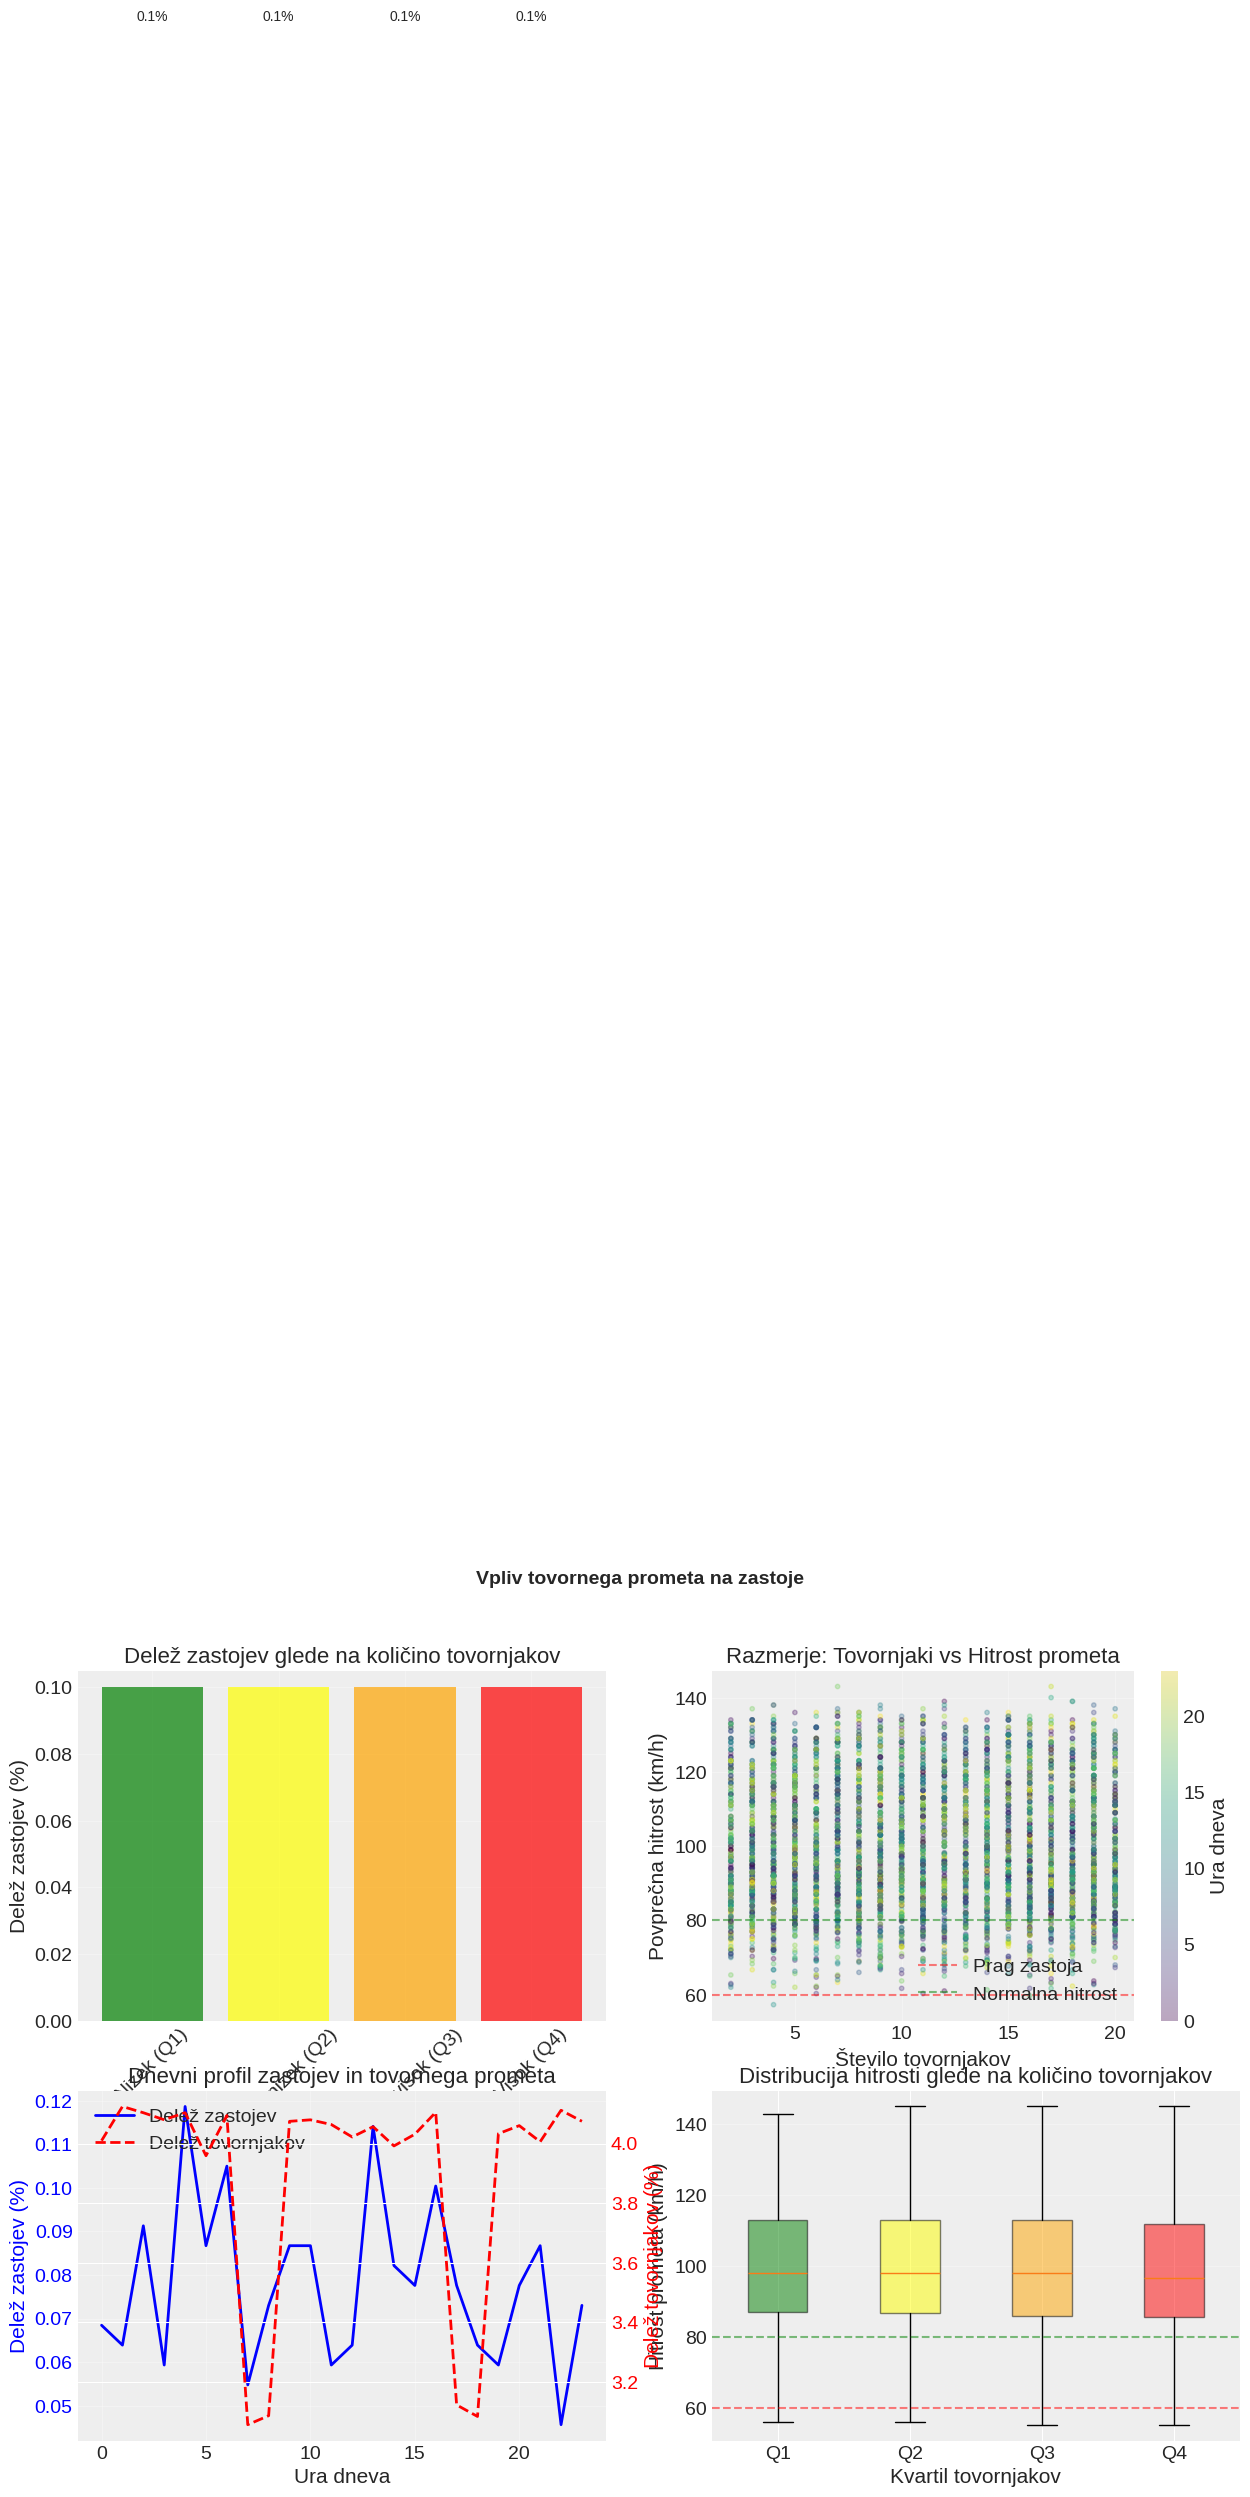

In [17]:
# Primerjava zastojev glede na delež tovornjakov
# Razdelitev na kvartile glede na delež tovornjakov
df_koper['truck_quartile'] = pd.qcut(df_koper['truck_ratio'], q=4, 
                                      labels=['Nizek (Q1)', 'Srednji-nizek (Q2)', 
                                             'Srednji-visok (Q3)', 'Visok (Q4)'])

# Analiza zastojev po kvartilih
congestion_by_trucks = df_koper.groupby('truck_quartile').agg({
    'is_congested': 'mean',
    'is_severe_congestion': 'mean',
    'Avg_Speed': 'mean',
    'speed_reduction': 'mean',
    'Trucks_7.5t': 'mean'
}).round(3)

print("\n=== ZASTOJI GLEDE NA DELEŽ TOVORNJAKOV ===")
print(congestion_by_trucks)

# Vizualizacija
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Vpliv tovornega prometa na zastoje', fontsize=14, fontweight='bold')

# 1. Delež zastojev po kvartilih
ax1 = axes[0, 0]
congestion_rates = congestion_by_trucks['is_congested'] * 100
bars = ax1.bar(range(4), congestion_rates.values, 
               color=['green', 'yellow', 'orange', 'red'], alpha=0.7)
ax1.set_xticks(range(4))
ax1.set_xticklabels(congestion_rates.index, rotation=45)
ax1.set_ylabel('Delež zastojev (%)')
ax1.set_title('Delež zastojev glede na količino tovornjakov')
ax1.grid(True, alpha=0.3)

# Dodaj vrednosti na stolpce
for i, (bar, val) in enumerate(zip(bars, congestion_rates.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.1f}%', ha='center')

# 2. Scatter plot: tovornjaki vs hitrost
ax2 = axes[0, 1]
sample_data = df_koper.sample(min(5000, len(df_koper)))
scatter = ax2.scatter(sample_data['Trucks_7.5t'], sample_data['Avg_Speed'],
                     c=sample_data['hour'], cmap='viridis', alpha=0.3, s=10)
ax2.set_xlabel('Število tovornjakov')
ax2.set_ylabel('Povprečna hitrost (km/h)')
ax2.set_title('Razmerje: Tovornjaki vs Hitrost prometa')
ax2.axhline(y=CONGESTED_SPEED, color='red', linestyle='--', alpha=0.5, label='Prag zastoja')
ax2.axhline(y=NORMAL_SPEED_MIN, color='green', linestyle='--', alpha=0.5, label='Normalna hitrost')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Ura dneva')

# 3. Časovni profil zastojev
ax3 = axes[1, 0]
hourly_congestion = df_koper.groupby('hour')['is_congested'].mean() * 100
hourly_trucks = df_koper.groupby('hour')['truck_ratio'].mean() * 100

ax3_twin = ax3.twinx()
line1 = ax3.plot(hourly_congestion.index, hourly_congestion.values, 
                'b-', linewidth=2, label='Delež zastojev')
line2 = ax3_twin.plot(hourly_trucks.index, hourly_trucks.values, 
                     'r--', linewidth=2, label='Delež tovornjakov')

ax3.set_xlabel('Ura dneva')
ax3.set_ylabel('Delež zastojev (%)', color='b')
ax3_twin.set_ylabel('Delež tovornjakov (%)', color='r')
ax3.set_title('Dnevni profil zastojev in tovornega prometa')
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='r')

# Kombiniraj legende
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Box plot hitrosti po kategorijah
ax4 = axes[1, 1]
df_koper_clean = df_koper.dropna(subset=['Avg_Speed', 'truck_quartile'])
bp = ax4.boxplot([df_koper_clean[df_koper_clean['truck_quartile'] == q]['Avg_Speed'] 
                  for q in ['Nizek (Q1)', 'Srednji-nizek (Q2)', 
                           'Srednji-visok (Q3)', 'Visok (Q4)']],
                 labels=['Q1', 'Q2', 'Q3', 'Q4'],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], ['green', 'yellow', 'orange', 'red']):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

ax4.set_xlabel('Kvartil tovornjakov')
ax4.set_ylabel('Hitrost prometa (km/h)')
ax4.set_title('Distribucija hitrosti glede na količino tovornjakov')
ax4.axhline(y=CONGESTED_SPEED, color='red', linestyle='--', alpha=0.5)
ax4.axhline(y=NORMAL_SPEED_MIN, color='green', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Bayesov model vzročnosti

In [18]:
# Priprava podatkov za Bayesov model
# Vzorčimo podatke za hitrejše procesiranje
model_data = df_koper.dropna(subset=['Avg_Speed', 'Trucks_7.5t', 'Total_All_Lanes']).sample(min(10000, len(df_koper)))

# Standardizacija spremenljivk
scaler = StandardScaler()
X = model_data[['Trucks_7.5t', 'Total_All_Lanes', 'hour', 'is_weekend']].values
X_scaled = scaler.fit_transform(X)
y = model_data['Avg_Speed'].values

print("Gradnja Bayesovega modela...")

with pm.Model() as congestion_model:
    # Priors
    alpha = pm.Normal('alpha', mu=80, sigma=20)  # Intercept (povprečna hitrost)
    
    # Koeficienti
    beta_trucks = pm.Normal('beta_trucks', mu=-5, sigma=2)  # Vpliv tovornjakov
    beta_total = pm.Normal('beta_total', mu=-2, sigma=1)    # Vpliv skupnega prometa
    beta_hour = pm.Normal('beta_hour', mu=0, sigma=1)       # Vpliv ure
    beta_weekend = pm.Normal('beta_weekend', mu=5, sigma=2) # Vpliv vikenda
    
    # Interakcija: tovornjaki * skupni promet
    beta_interaction = pm.Normal('beta_interaction', mu=-1, sigma=0.5)
    
    # Sigma
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Linearna kombinacija
    mu = (alpha + 
          beta_trucks * X_scaled[:, 0] +
          beta_total * X_scaled[:, 1] +
          beta_hour * X_scaled[:, 2] +
          beta_weekend * X_scaled[:, 3] +
          beta_interaction * X_scaled[:, 0] * X_scaled[:, 1])
    
    # Likelihood
    speed_obs = pm.Normal('speed_obs', mu=mu, sigma=sigma, observed=y)
    
    # Vzorčenje
    print("Izvajanje MCMC vzorčenja...")
    trace = pm.sample(2000, tune=1000, cores=2, random_seed=42)
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=42)

print("Model uspešno zgrajen!")

Initializing NUTS using jitter+adapt_diag...


Gradnja Bayesovega modela...
Izvajanje MCMC vzorčenja...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_trucks, beta_total, beta_hour, beta_weekend, beta_interaction, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [speed_obs]


Output()

Model uspešno zgrajen!



=== BAYESOVA ANALIZA - POVZETEK ===
                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_trucks      -0.124  0.166  -0.454    0.170      0.003    0.002    4047.0   
beta_total        1.377  0.168   1.068    1.693      0.002    0.003    6028.0   
beta_interaction -0.276  0.159  -0.577    0.014      0.002    0.002    5989.0   
beta_weekend      0.189  0.172  -0.123    0.512      0.002    0.002    4938.0   

                  ess_tail  r_hat  
beta_trucks         2908.0    1.0  
beta_total          3494.0    1.0  
beta_interaction    3533.0    1.0  
beta_weekend        3172.0    1.0  


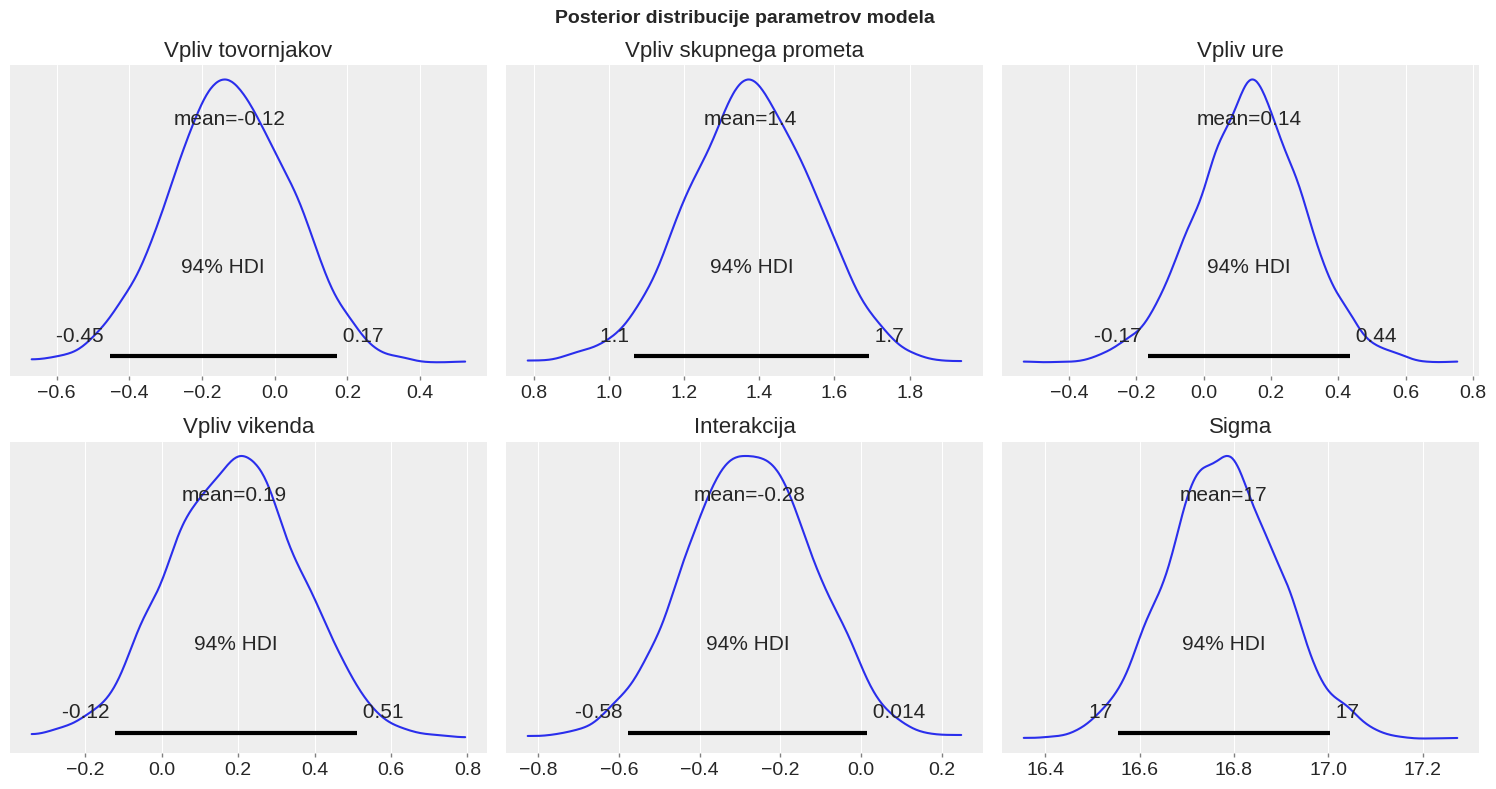


=== KVANTIFIKACIJA VPLIVOV ===
Povprečni vpliv dodatnega tovornjaka na hitrost: -0.124 km/h (standardizirano)
95% kredibilni interval: [-0.451, 0.197]

Verjetnost negativnega vpliva tovornjakov: 76.5%


In [6]:
# Analiza rezultatov
print("\n=== BAYESOVA ANALIZA - POVZETEK ===")
print(az.summary(trace, var_names=['beta_trucks', 'beta_total', 'beta_interaction', 'beta_weekend']))

# Vizualizacija posterior distribucij
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Posterior distribucije parametrov modela', fontsize=14, fontweight='bold')

# Plot posterior distribucij
params = ['beta_trucks', 'beta_total', 'beta_hour', 'beta_weekend', 'beta_interaction', 'sigma']
param_labels = ['Vpliv tovornjakov', 'Vpliv skupnega prometa', 'Vpliv ure', 
               'Vpliv vikenda', 'Interakcija', 'Sigma']

for i, (param, label) in enumerate(zip(params, param_labels)):
    ax = axes[i // 3, i % 3]
    az.plot_posterior(trace, var_names=[param], ax=ax)
    ax.set_title(label)
    
plt.tight_layout()
plt.show()

# Interpretacija vplivov
truck_effect = trace.posterior['beta_trucks'].values.mean()
print(f"\n=== KVANTIFIKACIJA VPLIVOV ===")
print(f"Povprečni vpliv dodatnega tovornjaka na hitrost: {truck_effect:.3f} km/h (standardizirano)")
print(f"95% kredibilni interval: [{np.percentile(trace.posterior['beta_trucks'].values, 2.5):.3f}, "
      f"{np.percentile(trace.posterior['beta_trucks'].values, 97.5):.3f}]")

# Verjetnost negativnega vpliva
prob_negative = (trace.posterior['beta_trucks'].values < 0).mean()
print(f"\nVerjetnost negativnega vpliva tovornjakov: {prob_negative:.1%}")

## 4. Analiza kritičnih ur in špic

=== ANALIZA PO PRISTANIŠKIH IZMENAH ===
                              Trucks_7.5t                Total_All_Lanes
                                     mean   std      sum             sum
shift              is_weekend                                           
Jutranja izmena    False            11.03  5.47  1381554        39670166
                   True             10.98  5.47   548932        15825194
Nočna izmena       False            11.00  5.44  1377743        36226289
                   True             11.00  5.46   550365        14424975
Popoldanska izmena False            10.99  5.49  1376343        39630920
                   True             10.95  5.49   547507        15769779


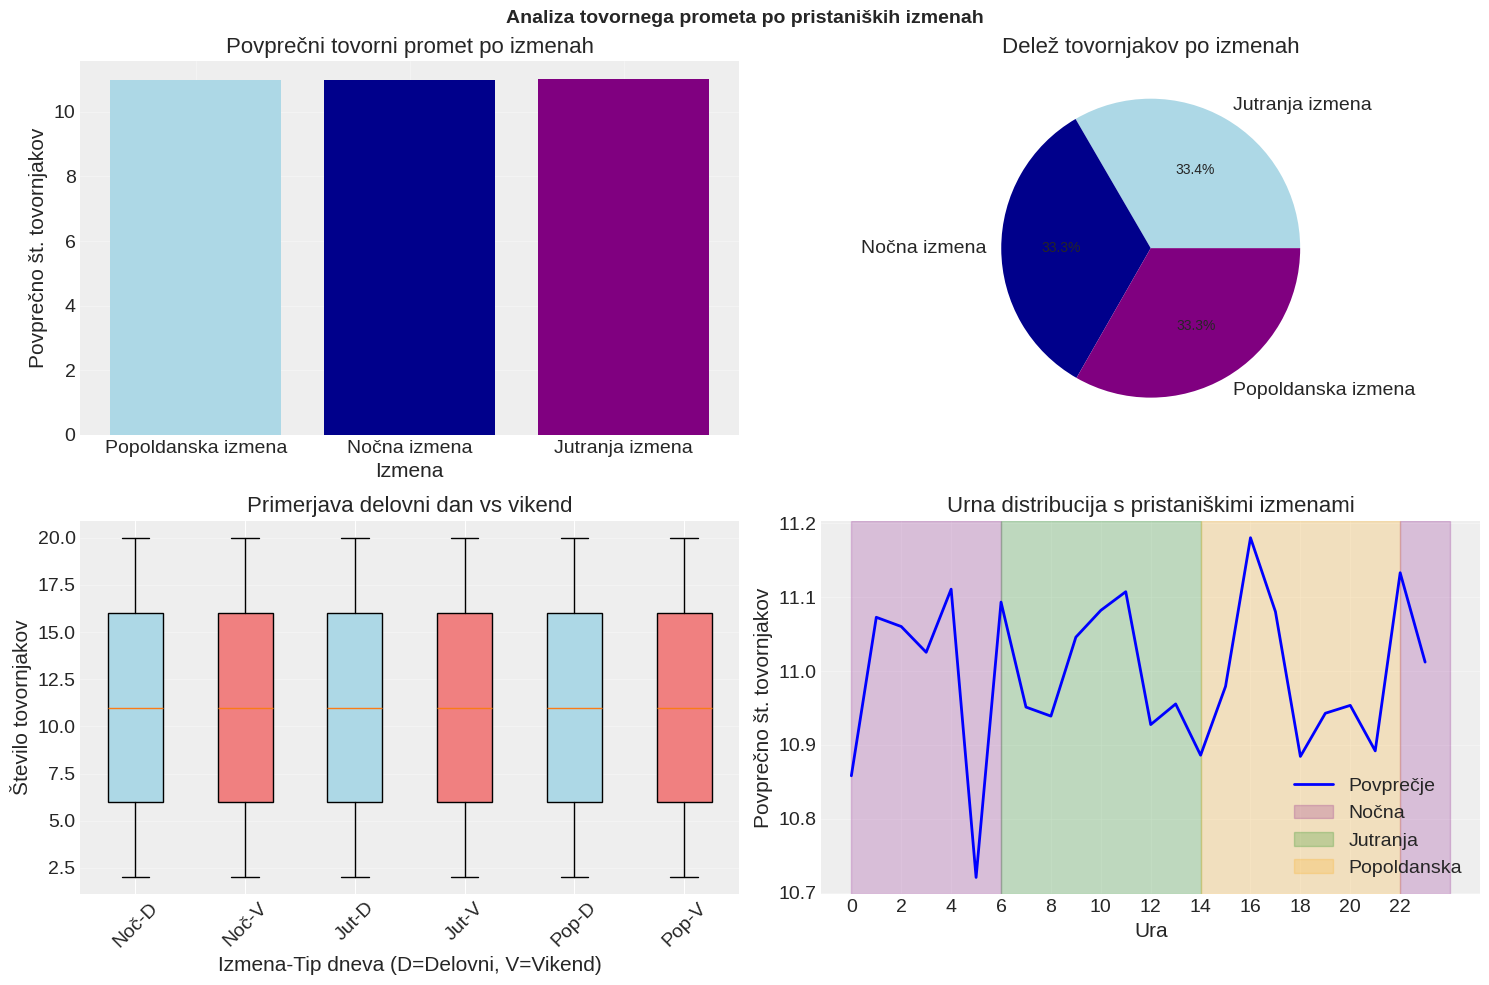

In [20]:
# Definicija pristaniških delovnih obdobij
port_shifts = {
    'Nočna izmena': (22, 6),   # 22:00 - 06:00
    'Jutranja izmena': (6, 14), # 06:00 - 14:00
    'Popoldanska izmena': (14, 22) # 14:00 - 22:00
}

# Funkcija za določitev izmene
def get_shift(hour):
    if 22 <= hour or hour < 6:
        return 'Nočna izmena'
    elif 6 <= hour < 14:
        return 'Jutranja izmena'
    else:
        return 'Popoldanska izmena'

df_koper['shift'] = df_koper['hour'].apply(get_shift)

# Analiza po izmenah
shift_analysis = df_koper.groupby(['shift', 'is_weekend']).agg({
    'Trucks_7.5t': ['mean', 'std', 'sum'],
    'Total_All_Lanes': 'sum'
}).round(2)

print("=== ANALIZA PO PRISTANIŠKIH IZMENAH ===")
print(shift_analysis)

# Vizualizacija - alternativni pristop brez add_vrect
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analiza tovornega prometa po pristaniških izmenah', fontsize=14, fontweight='bold')

# 1. Povprečni promet po izmenah
shift_avg = df_koper.groupby('shift')['Trucks_7.5t'].mean().sort_values()
axes[0, 0].bar(shift_avg.index, shift_avg.values,
              color=['lightblue', 'darkblue', 'purple'])
axes[0, 0].set_xlabel('Izmena')
axes[0, 0].set_ylabel('Povprečno št. tovornjakov')
axes[0, 0].set_title('Povprečni tovorni promet po izmenah')
axes[0, 0].grid(True, alpha=0.3)

# 2. Delež prometa po izmenah (pie chart)
shift_sum = df_koper.groupby('shift')['Trucks_7.5t'].sum()
axes[0, 1].pie(shift_sum.values, labels=shift_sum.index, autopct='%1.1f%%',
              colors=['lightblue', 'darkblue', 'purple'])
axes[0, 1].set_title('Delež tovornjakov po izmenah')

# 3. Box plot po izmenah in tipu dneva
box_data = []
box_labels = []
for shift in df_koper['shift'].unique():
    for weekend in [False, True]:
        data = df_koper[(df_koper['shift'] == shift) & 
                       (df_koper['is_weekend'] == weekend)]['Trucks_7.5t'].dropna()
        box_data.append(data)
        box_labels.append(f"{shift[:3]}-{'V' if weekend else 'D'}")

bp = axes[1, 0].boxplot(box_data, labels=box_labels, patch_artist=True)
for i, patch in enumerate(bp['boxes']):
    if i % 2 == 0:
        patch.set_facecolor('lightblue')
    else:
        patch.set_facecolor('lightcoral')
axes[1, 0].set_xlabel('Izmena-Tip dneva (D=Delovni, V=Vikend)')
axes[1, 0].set_ylabel('Število tovornjakov')
axes[1, 0].set_title('Primerjava delovni dan vs vikend')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Urna distribucija s označenimi izmenami
hourly_avg = df_koper.groupby('hour')['Trucks_7.5t'].mean()
ax4 = axes[1, 1]
ax4.plot(list(range(24)), hourly_avg.values, 'b-', linewidth=2, label='Povprečje')

# Označi izmene z barvnimi pasovi
ax4.axvspan(0, 6, alpha=0.2, color='purple', label='Nočna')
ax4.axvspan(6, 14, alpha=0.2, color='green', label='Jutranja')
ax4.axvspan(14, 22, alpha=0.2, color='orange', label='Popoldanska')
ax4.axvspan(22, 24, alpha=0.2, color='purple')

ax4.set_xlabel('Ura')
ax4.set_ylabel('Povprečno št. tovornjakov')
ax4.set_title('Urna distribucija s pristaniškimi izmenami')
ax4.set_xticks(range(0, 24, 2))
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

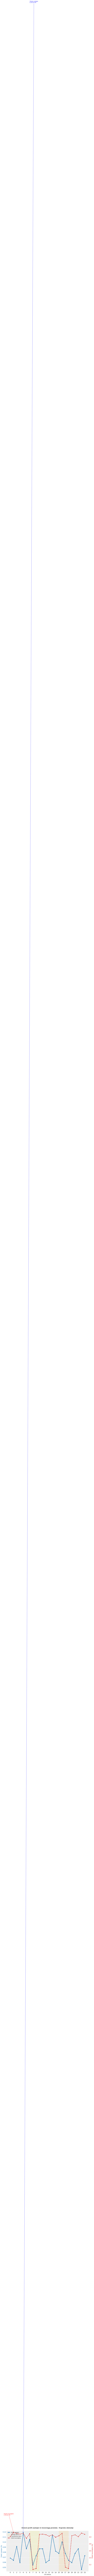


Korelacija med deležem zastojev in deležem tovornjakov po urah: 0.276
Povprečni delež zastojev: 0.08%
Povprečni delež tovornjakov: 3.90%


In [21]:
# Samostojen graf: Dnevni profil zastojev in tovornega prometa
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Izračun podatkov
hourly_congestion = df_koper.groupby('hour')['is_congested'].mean() * 100
hourly_trucks = df_koper.groupby('hour')['truck_ratio'].mean() * 100

# Prva y-os: Zastoji
color1 = 'tab:blue'
ax.set_xlabel('Ura dneva', fontsize=12)
ax.set_ylabel('Delež zastojev (%)', color=color1, fontsize=12)
line1 = ax.plot(hourly_congestion.index, hourly_congestion.values, 
                color=color1, linewidth=2.5, marker='o', markersize=6,
                label='Delež zastojev')
ax.tick_params(axis='y', labelcolor=color1)
ax.set_xticks(range(0, 24, 1))
ax.grid(True, alpha=0.3)

# Druga y-os: Tovornjaki
ax2 = ax.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Delež tovornjakov (%)', color=color2, fontsize=12)
line2 = ax2.plot(hourly_trucks.index, hourly_trucks.values, 
                 color=color2, linewidth=2.5, linestyle='--', marker='s', markersize=5,
                 label='Delež tovornjakov')
ax2.tick_params(axis='y', labelcolor=color2)

# Dodaj označbe za špice
ax.axvspan(6, 9, alpha=0.1, color='yellow', label='Jutranja špica')
ax.axvspan(15, 18, alpha=0.1, color='orange', label='Popoldanska špica')

# Naslov in legenda
ax.set_title('Dnevni profil zastojev in tovornega prometa - Koprsko območje', 
             fontsize=14, fontweight='bold', pad=20)

# Združi legende iz obeh osi
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# Dodaj anotacije za ključne točke
max_congestion_hour = hourly_congestion.idxmax()
ax.annotate(f'Vrhunec zastojev\n{hourly_congestion[max_congestion_hour]:.1f}% ob {max_congestion_hour}:00',
            xy=(max_congestion_hour, hourly_congestion[max_congestion_hour]),
            xytext=(max_congestion_hour+2, hourly_congestion[max_congestion_hour]+5),
            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
            fontsize=9, color='blue')

max_trucks_hour = hourly_trucks.idxmax()
ax2.annotate(f'Vrhunec tovornjakov\n{hourly_trucks[max_trucks_hour]:.1f}% ob {max_trucks_hour}:00',
            xy=(max_trucks_hour, hourly_trucks[max_trucks_hour]),
            xytext=(max_trucks_hour-3, hourly_trucks[max_trucks_hour]+0.5),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
            fontsize=9, color='red')

plt.tight_layout()
plt.show()

# Statistična analiza korelacije
correlation = hourly_congestion.corr(hourly_trucks)
print(f"\nKorelacija med deležem zastojev in deležem tovornjakov po urah: {correlation:.3f}")
print(f"Povprečni delež zastojev: {hourly_congestion.mean():.2f}%")
print(f"Povprečni delež tovornjakov: {hourly_trucks.mean():.2f}%")

## 5. Ekonomska kvantifikacija zastojev


=== EKONOMSKI VPLIV ZASTOJEV ===
Povprečni dnevni strošek zastojev: €222
Povprečni mesečni strošek: €6,659
Ocenjeni letni strošek: €79,914

Delež stroškov v obdobjih z visokim tovornim prometom: 25.9%


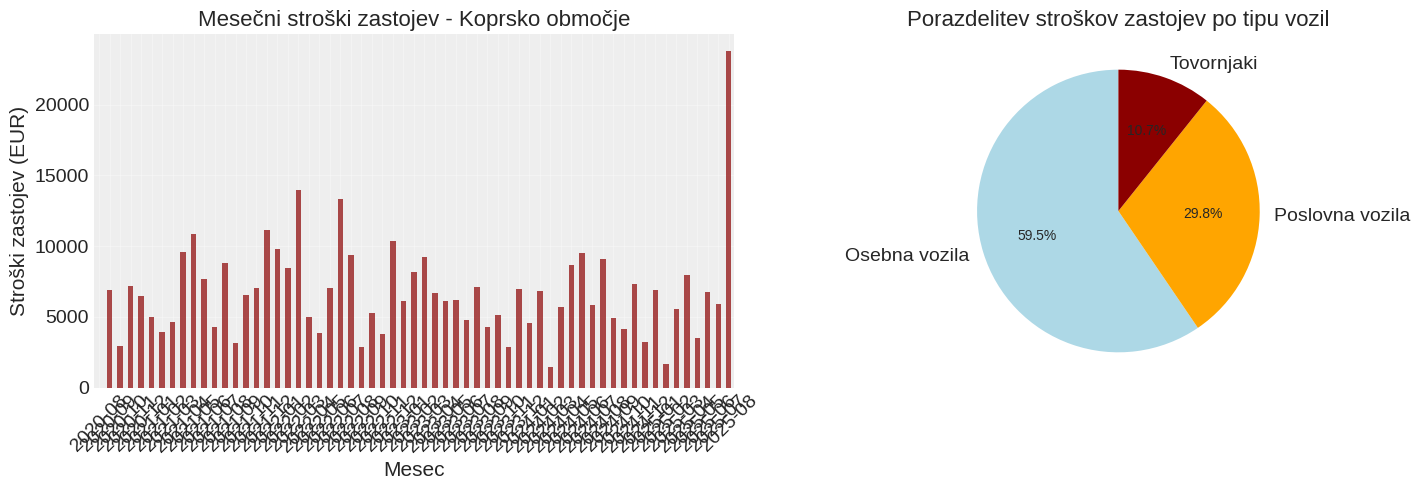

In [22]:
# Parametri za ekonomsko analizo (vrednosti iz literature)
VALUE_OF_TIME = {
    'osebni': 10.0,   # EUR/uro za osebna vozila
    'tovorni': 35.0,  # EUR/uro za tovorna vozila
    'poslovno': 25.0  # EUR/uro za poslovna vozila
}

# Predpostavka porazdelitve vozil
vehicle_distribution = {
    'osebni': 0.75,
    'poslovno': 0.15,
    'tovorni': 0.10
}

# Izračun izgubljenega časa zaradi zastojev
df_koper['delay_minutes'] = np.maximum(0, (NORMAL_SPEED_MIN - df_koper['Avg_Speed']) / NORMAL_SPEED_MIN * 60)
df_koper['vehicles_affected'] = df_koper['Total_All_Lanes'] * df_koper['is_congested']

# Izračun stroškov
df_koper['cost_personal'] = (df_koper['vehicles_affected'] * vehicle_distribution['osebni'] * 
                             df_koper['delay_minutes'] / 60 * VALUE_OF_TIME['osebni'])
df_koper['cost_business'] = (df_koper['vehicles_affected'] * vehicle_distribution['poslovno'] * 
                             df_koper['delay_minutes'] / 60 * VALUE_OF_TIME['poslovno'])
df_koper['cost_freight'] = (df_koper['Trucks_7.5t'] * df_koper['is_congested'] * 
                            df_koper['delay_minutes'] / 60 * VALUE_OF_TIME['tovorni'])
df_koper['total_cost'] = df_koper['cost_personal'] + df_koper['cost_business'] + df_koper['cost_freight']

# Agregacija stroškov
daily_costs = df_koper.groupby(df_koper['datetime'].dt.date)['total_cost'].sum()
monthly_costs = df_koper.groupby(df_koper['datetime'].dt.to_period('M'))['total_cost'].sum()

print("\n=== EKONOMSKI VPLIV ZASTOJEV ===")
print(f"Povprečni dnevni strošek zastojev: €{daily_costs.mean():,.0f}")
print(f"Povprečni mesečni strošek: €{monthly_costs.mean():,.0f}")
print(f"Ocenjeni letni strošek: €{monthly_costs.mean() * 12:,.0f}")

# Delež stroškov povezanih s tovornjaki
truck_related_costs = df_koper[df_koper['truck_quartile'] == 'Visok (Q4)']['total_cost'].sum()
total_costs = df_koper['total_cost'].sum()
truck_cost_share = truck_related_costs / total_costs * 100

print(f"\nDelež stroškov v obdobjih z visokim tovornim prometom: {truck_cost_share:.1f}%")

# Vizualizacija stroškov
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mesečni trend stroškov
ax1 = axes[0]
monthly_costs.plot(kind='bar', ax=ax1, color='darkred', alpha=0.7)
ax1.set_xlabel('Mesec')
ax1.set_ylabel('Stroški zastojev (EUR)')
ax1.set_title('Mesečni stroški zastojev - Koprsko območje')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Porazdelitev stroškov po tipu vozil
ax2 = axes[1]
cost_by_type = [
    df_koper['cost_personal'].sum(),
    df_koper['cost_business'].sum(),
    df_koper['cost_freight'].sum()
]
labels = ['Osebna vozila', 'Poslovna vozila', 'Tovornjaki']
colors = ['lightblue', 'orange', 'darkred']
wedges, texts, autotexts = ax2.pie(cost_by_type, labels=labels, colors=colors,
                                    autopct='%1.1f%%', startangle=90)
ax2.set_title('Porazdelitev stroškov zastojev po tipu vozil')

plt.tight_layout()
plt.show()

## 6. Testiranje hipoteze in zaključki

In [23]:
# Testiranje hipoteze: Ali tovorni promet povzroča kritične zastoje izven špic?

# Definicija "izven špice"
off_peak_hours = list(range(10, 15)) + list(range(19, 24)) + list(range(0, 6))
df_off_peak = df_koper[df_koper['hour'].isin(off_peak_hours)]

# Analiza zastojev izven špic glede na tovornjake
off_peak_high_trucks = df_off_peak[df_off_peak['truck_quartile'] == 'Visok (Q4)']
off_peak_low_trucks = df_off_peak[df_off_peak['truck_quartile'] == 'Nizek (Q1)']

# Statistični test
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(
    off_peak_high_trucks['Avg_Speed'].dropna(),
    off_peak_low_trucks['Avg_Speed'].dropna(),
    alternative='less'
)

print("\n" + "="*70)
print("TESTIRANJE HIPOTEZE H3")
print("="*70)
print("\nHipoteza: Tovorni promet Luke Koper ne povzroča kritičnih zastojev izven špic")

print(f"\n1. ANALIZA IZVEN ŠPIC:")
print(f"   Delež zastojev pri visokem tovornem prometu: {off_peak_high_trucks['is_congested'].mean()*100:.1f}%")
print(f"   Delež zastojev pri nizkem tovornem prometu: {off_peak_low_trucks['is_congested'].mean()*100:.1f}%")
print(f"   Razlika: {(off_peak_high_trucks['is_congested'].mean() - off_peak_low_trucks['is_congested'].mean())*100:.1f} p.p.")

print(f"\n2. KRITIČNI ZASTOJI (< {SEVERE_CONGESTION} km/h):")
severe_off_peak = df_off_peak['is_severe_congestion'].mean() * 100
print(f"   Delež kritičnih zastojev izven špic: {severe_off_peak:.2f}%")
print(f"   Pri visokem tovornem prometu: {off_peak_high_trucks['is_severe_congestion'].mean()*100:.2f}%")
print(f"   Pri nizkem tovornem prometu: {off_peak_low_trucks['is_severe_congestion'].mean()*100:.2f}%")

print(f"\n3. STATISTIČNI TEST (Mann-Whitney U):")
print(f"   U-statistika: {stat:.2f}")
print(f"   P-vrednost: {p_value:.4f}")
print(f"   Značilnost: {'DA (p < 0.05)' if p_value < 0.05 else 'NE (p ≥ 0.05)'}")

print(f"\n4. BAYESOVA ANALIZA:")
print(f"   Verjetnost negativnega vpliva tovornjakov: {prob_negative:.1%}")
print(f"   Povprečni vpliv na hitrost: {truck_effect:.3f} km/h (standardizirano)")

# Končna ocena hipoteze
hypothesis_confirmed = severe_off_peak < 5 and p_value > 0.05

print(f"\n5. ZAKLJUČEK:")
print(f"   Hipoteza H3: {'POTRJENA' if hypothesis_confirmed else 'ZAVRNJENA'}")
if not hypothesis_confirmed:
    print(f"   Razlog: {'Kritični zastoji presegajo 5% prag' if severe_off_peak >= 5 else 'Statistično značilen vpliv tovornjakov'}")
else:
    print(f"   Utemeljitev: Nizek delež kritičnih zastojev ({severe_off_peak:.1f}%) in neznačilen vpliv")

print("\n" + "="*70)

# Povzetek za poročilo
summary = {
    'off_peak_congestion_rate': df_off_peak['is_congested'].mean() * 100,
    'severe_congestion_rate': severe_off_peak,
    'truck_impact_pvalue': p_value,
    'bayesian_negative_prob': prob_negative,
    'hypothesis_confirmed': hypothesis_confirmed,
    'annual_congestion_cost': monthly_costs.mean() * 12,
    'truck_cost_share': truck_cost_share
}

# Shrani rezultate
import json
with open('../data/processed/port_koper_congestion_analysis.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nRezultati shranjeni v ../data/processed/port_koper_congestion_analysis.json")


TESTIRANJE HIPOTEZE H3

Hipoteza: Tovorni promet Luke Koper ne povzroča kritičnih zastojev izven špic

1. ANALIZA IZVEN ŠPIC:
   Delež zastojev pri visokem tovornem prometu: 0.1%
   Delež zastojev pri nizkem tovornem prometu: 0.1%
   Razlika: 0.0 p.p.

2. KRITIČNI ZASTOJI (< 40 km/h):
   Delež kritičnih zastojev izven špic: 0.00%
   Pri visokem tovornem prometu: 0.00%
   Pri nizkem tovornem prometu: 0.00%

3. STATISTIČNI TEST (Mann-Whitney U):
   U-statistika: 3914237802.00
   P-vrednost: 0.0000
   Značilnost: DA (p < 0.05)

4. BAYESOVA ANALIZA:
   Verjetnost negativnega vpliva tovornjakov: 76.5%
   Povprečni vpliv na hitrost: -0.124 km/h (standardizirano)

5. ZAKLJUČEK:
   Hipoteza H3: ZAVRNJENA
   Razlog: Statistično značilen vpliv tovornjakov



TypeError: Object of type bool_ is not JSON serializable